Best: 0.994188320759989 using {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__units1': 100, 'model__units2': 50}
Validation set accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       326
           1       1.00      1.00      1.00       221
           2       1.00      1.00      1.00       505
           3       0.99      0.99      0.99       264
           4       0.99      1.00      0.99       270
           5       1.00      1.00      1.00       535
           6       1.00      1.00      1.00       384
           7       1.00      1.00      1.00       248

    accuracy                           1.00      2753
   macro avg       1.00      1.00      1.00      2753
weighted avg       1.00      1.00      1.00      2753


Confusion Matrix:
[[326   0   0   0   0   0   0   0]
 [  0 221   0   0   0   0   0   0]
 [  0   0 503   2   0   0   0   0]
 [  0   0   0 262   2   0   0   0]
 [

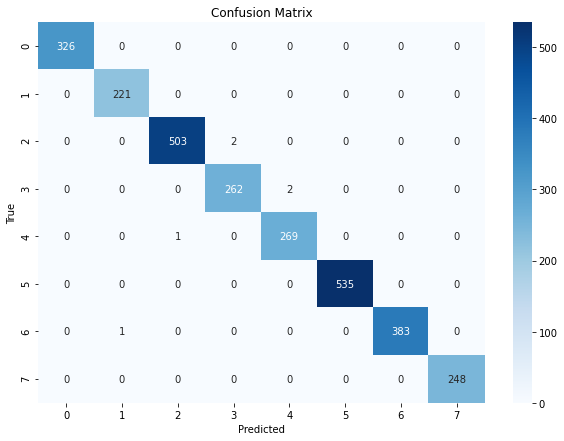

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv('Sets/pca_time_freq/train_data_pca_time_freq.csv')
val_data = pd.read_csv('Sets/pca_time_freq/val_data_pca_time_freq.csv')

# Separate features and labels
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_val = val_data.drop(columns=['label'])
y_val = val_data['label']

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data to 3D for LSTM (samples, timesteps, features)
# Assuming each sample represents a 0.5-second window and no further time segmentation is needed
timesteps = 1  # Since each row is already a window, timesteps is 1
n_features = X_train_scaled.shape[1]

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, n_features))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], timesteps, n_features))

# Function to create the LSTM model
def create_model(units1=50, units2=25, dropout_rate=0.5):
    model = Sequential()
    model.add(LSTM(units1, input_shape=(timesteps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model for use in scikit-learn
model = KerasClassifier(model=create_model, verbose=0)

# Define the grid of hyperparameters to search
param_grid = {
    'model__units1': [50, 100],
    'model__units2': [25, 50],
    'model__dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64],
    'epochs': [20, 50]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose = 1)
grid_result = grid.fit(X_train_reshaped, y_train_one_hot)

# Display the best hyperparameters
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Train the best model
best_model = grid_result.best_estimator_
best_model.fit(X_train_reshaped, y_train_one_hot)

# Evaluate the best model
val_predicted_probs = best_model.predict(X_val_reshaped)
val_predicted_labels = np.argmax(val_predicted_probs, axis=1)
val_true_labels = np.argmax(y_val_one_hot, axis=1)

# Calculate accuracy
accuracy = accuracy_score(val_true_labels, val_predicted_labels)
print(f'Validation set accuracy: {accuracy:.2f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_predicted_labels, target_names=label_encoder.classes_.astype(str)))

# Print confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()